In [1]:
import numpy as np
import talib
import pandas as pd
import os
import talib as ta
import time
import datetime

## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error

#for logging
import time

##matrix math
import math

##plotting
import matplotlib.pyplot as plt


#change working directory
os.chdir("D:/Graduate Courses/2019 Dissertation/Data/Other.coins")
print("Current Working Directory " , os.getcwd())

Using TensorFlow backend.


Current Working Directory  D:\Graduate Courses\2019 Dissertation\Data\Other.coins


In [2]:
def load_data(filename, window_length,percent):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    
    Returns:
    if window=30
    X_train -- A tensor of shape (2492, 30, 105) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2492,) that will be inputed into the model to train it
    X_test -- A tensor of shape (623, 30, 105) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (623,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (623,) that represents the price of bitcoin the day before each Y_test value
    """
    
    #Read the data file, and set index
    dataset_total = pd.read_csv(filename,na_values='n/a',parse_dates=['Date'],index_col="Date")
     
    #normalize dataset
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    dataset_total_scaled = sc.fit_transform(dataset_total)
    X_normal=dataset_total_scaled[:,:-1]
    
    # slice the target dataset
    from keras.utils import to_categorical
    Y=to_categorical(dataset_total.iloc[:,-1],21)
    
   
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    data = X_normal.tolist()
    result = []
    for index in range(len(data) - window_length):
        result.append(data[index: index + window_length])

    data_reshape=np.array(result)
    data_reshape.shape

    #Splitting data set into training (First 80% of data points) and testing data (last 20% of data points)
    split_line = round(percent * data_reshape.shape[0])
    X_train = data_reshape[:int(split_line), :]
    Y_train = Y[window_length:int(split_line)+window_length]
    X_test = data_reshape[int(split_line):,:]
    Y_test = Y[int(split_line)+window_length:]
    Y_daybefore = Y[int(split_line)+window_length-1:-1]
    return X_train, Y_train, X_test, Y_test, window_length,dataset_total,Y_daybefore,split_line

def initialize_model(dropout_rate):
    """
    Initializes and creates the model to be used
    
    Arguments:
    dropout_rate -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
  
    #Build the model
    model=Sequential()

    input_shape=(window_length, X_train.shape[-1])

    optimizer='adam'
    loss='categorical_crossentropy'
    
    model.add(LSTM(units = 32, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units = 32, activation='relu'))
    
    
    model.add(LSTM(units = 32, return_sequences = False))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units = 21,activation='softmax'))
    
   

    
              
    model.compile(optimizer =optimizer, loss = loss, metrics=['accuracy'])

    
    return model

#Training the model

def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2492, 30, 105) that represents the x values of the training data
    Y_train -- A tensor of shape (2492,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 100
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
   

    #Train the model on X_train and Y_train
    history=model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    return model,history

def model_predictions(model, X_test, Y_test):
    predictions=model.predict(X_test)
    predictions=pd.DataFrame(predictions)
    
    #reverse the column name to the original return range 
    col_name= list(range(-10,11))
    predictions.columns=col_name
    
    return predictions


def find_the_successful_rate(predictions):
    #find the predict range(assume the model will predict the range with the highest probability)
    y_predict_list=[]
    for i in range(predictions.shape[0]):
        max_num=predictions.iloc[i,:].max()
        y_predict_list.append(predictions.columns[predictions.iloc[i,:]==max_num].values)
    np.array(y_predict_list)

    predictions['Predicted_range']=np.array(y_predict_list)
    predictions['True_range']=np.array(dataset_total.iloc[int(split_line)+window_length:,-1])
    
    predictions.plot(y='Predicted_range',kind='hist')
    predictions.plot(y='True_range',kind='hist')
    #compare the real range and predicted range and then calculate the successful predict range
    successful_number=0
    for i in range(predictions.shape[0]):
        if predictions['Predicted_range'][i]==predictions['True_range'][i]:
            successful_number+=1
    successful_rate=round(successful_number/predictions.shape[0],4)
    
    
    return successful_rate


(396, 30, 98)
(396, 21)
(179, 30, 98)
(179, 21)
30
(179, 21)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 32)            16768     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________________________

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 356 samples, validate on 40 samples
Epoch 1/100
356/356 [==============================] - 2s 7ms/step - loss: 2.9100 - acc: 0.1320 - val_loss: 2.8632 - val_acc: 0.1500
Epoch 2/100
356/356 [==============================] - 0s 709us/step - loss: 2.3702 - acc: 0.3596 - val_loss: 2.7619 - val_acc: 0.1500
Epoch 3/100
356/356 [==============================] - 0s 720us/step - loss: 2.0582 - acc: 0.3736 - val_loss: 2.8501 - val_acc: 0.1500
Epoch 4/100
356/356 [==============================] - 0s 709us/step - loss: 1.9940 - acc: 0.3371 - val_loss: 2.8737 - val_acc: 0.1500
Epoch 5/100
356/356 [==============================] - 0s 703us/step - loss: 1.9701 - acc: 0.3680 - val_loss: 2.8747 - val_acc: 0.1500
Epoch 6/100
356/356 [==============================] - 0s 695us/step - loss: 1.9686 - acc: 0.3708 - val_loss: 2.9058 - val_acc: 0.1500
Epoch 7/100
356/356 [==============================] - 0s 700us/step - loss: 1.9187 - acc: 0.4185 - val_loss: 2.8743 - val_acc: 0.1500
Epoch 8/100


356/356 [==============================] - 0s 1ms/step - loss: 1.8154 - acc: 0.4438 - val_loss: 2.9450 - val_acc: 0.2250
Epoch 62/100
356/356 [==============================] - 1s 1ms/step - loss: 1.8073 - acc: 0.4073 - val_loss: 2.9373 - val_acc: 0.2250
Epoch 63/100
356/356 [==============================] - 0s 1ms/step - loss: 1.7937 - acc: 0.4157 - val_loss: 2.9322 - val_acc: 0.2500
Epoch 64/100
356/356 [==============================] - 0s 1ms/step - loss: 1.8106 - acc: 0.4045 - val_loss: 2.9502 - val_acc: 0.2500
Epoch 65/100
356/356 [==============================] - 1s 1ms/step - loss: 1.8002 - acc: 0.3961 - val_loss: 2.9373 - val_acc: 0.2750
Epoch 66/100
356/356 [==============================] - 0s 1ms/step - loss: 1.8009 - acc: 0.4326 - val_loss: 2.9358 - val_acc: 0.2000
Epoch 67/100
356/356 [==============================] - 0s 1ms/step - loss: 1.8080 - acc: 0.4242 - val_loss: 2.9268 - val_acc: 0.1750
Epoch 68/100
356/356 [==============================] - 0s 1ms/step - loss:

0.0223

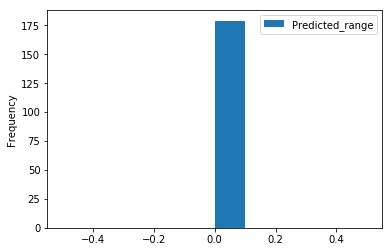

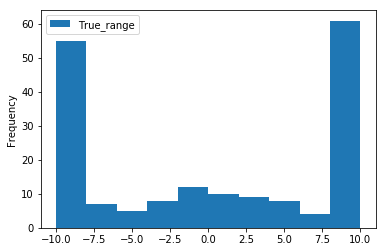

In [3]:
#compile together
#EOS
name=['classification_ merge_EOS-USD.csv','classification_ merge_ZEC-USD.csv','classification_ merge_ETH-USD.csv','classification_ merge_XRP-USD.csv','classification_ merge_LTC-USD.csv']

X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,split_line= load_data(name[0], 30,0.6880)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

model = initialize_model(0.2)
print (model.summary())

model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

successful_rate=find_the_successful_rate(predictions)
successful_rate


(639, 30, 112)
(639, 21)
(180, 30, 112)
(180, 21)
30
(180, 21)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 32)            18560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 21)                693       
Total params: 28,629
Trainable params: 28,629
Non-trainable params: 0
_________

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 575 samples, validate on 64 samples
Epoch 1/100
575/575 [==============================] - 4s 7ms/step - loss: 2.6360 - acc: 0.2939 - val_loss: 2.5673 - val_acc: 0.2500
Epoch 2/100
575/575 [==============================] - 1s 1ms/step - loss: 2.0939 - acc: 0.3357 - val_loss: 2.5921 - val_acc: 0.2500
Epoch 3/100
575/575 [==============================] - 1s 1ms/step - loss: 2.0159 - acc: 0.3617 - val_loss: 2.5498 - val_acc: 0.2656
Epoch 4/100
575/575 [==============================] - 1s 1ms/step - loss: 1.9768 - acc: 0.3513 - val_loss: 2.5244 - val_acc: 0.2656
Epoch 5/100
575/575 [==============================] - 1s 1ms/step - loss: 2.0027 - acc: 0.3583 - val_loss: 2.5294 - val_acc: 0.2656
Epoch 6/100
575/575 [==============================] - 1s 1ms/step - loss: 1.9961 - acc: 0.3530 - val_loss: 2.5287 - val_acc: 0.2656
Epoch 7/100
575/575 [==============================] - 1s 1ms/step - loss: 1.9633 - acc: 0.3600 - val_loss: 2.5281 - val_acc: 0.2188
Epoch 8/100
575/575 [===

575/575 [==============================] - 1s 1ms/step - loss: 1.8439 - acc: 0.4330 - val_loss: 2.4901 - val_acc: 0.2500
Epoch 62/100
575/575 [==============================] - 1s 1ms/step - loss: 1.8601 - acc: 0.4017 - val_loss: 2.4631 - val_acc: 0.2812
Epoch 63/100
575/575 [==============================] - 1s 1ms/step - loss: 1.8423 - acc: 0.4209 - val_loss: 2.4816 - val_acc: 0.3281
Epoch 64/100
575/575 [==============================] - 1s 1ms/step - loss: 1.8519 - acc: 0.4052 - val_loss: 2.5278 - val_acc: 0.3125
Epoch 65/100
575/575 [==============================] - 1s 1ms/step - loss: 1.8735 - acc: 0.4139 - val_loss: 2.4708 - val_acc: 0.2812
Epoch 66/100
575/575 [==============================] - 1s 1ms/step - loss: 1.8437 - acc: 0.4191 - val_loss: 2.5116 - val_acc: 0.2500
Epoch 67/100
575/575 [==============================] - 1s 1ms/step - loss: 1.8584 - acc: 0.4157 - val_loss: 2.4528 - val_acc: 0.3281
Epoch 68/100
575/575 [==============================] - 1s 1ms/step - loss:

0.0444

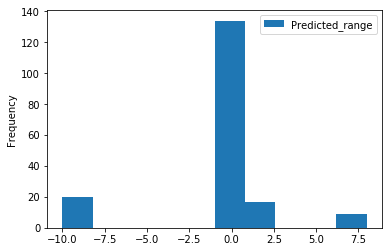

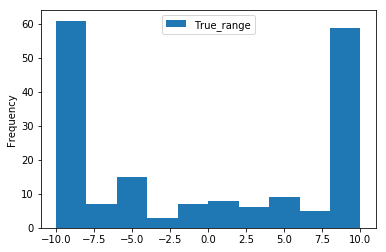

In [4]:
#compile together
#ZEC
name=['classification_ merge_EOS-USD.csv','classification_ merge_ZEC-USD.csv','classification_ merge_ETH-USD.csv','classification_ merge_XRP-USD.csv','classification_ merge_LTC-USD.csv']

X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,split_line= load_data(name[1], 30,0.7808)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

model = initialize_model(0.2)
print (model.summary())

model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

successful_rate=find_the_successful_rate(predictions)
successful_rate


(1285, 30, 110)
(1285, 21)
(180, 30, 110)
(180, 21)
30
(180, 21)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 32)            18304     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 21)                693       
Total params: 28,373
Trainable params: 28,373
Non-trainable params: 0
_______

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1156 samples, validate on 129 samples
Epoch 1/100
1156/1156 [==============================] - 6s 5ms/step - loss: 2.5193 - acc: 0.2933 - val_loss: 2.2769 - val_acc: 0.3178
Epoch 2/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.2171 - acc: 0.3192 - val_loss: 2.2420 - val_acc: 0.3178
Epoch 3/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.1953 - acc: 0.3304 - val_loss: 2.2517 - val_acc: 0.3178
Epoch 4/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.1962 - acc: 0.3131 - val_loss: 2.2387 - val_acc: 0.3178
Epoch 5/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.1828 - acc: 0.3131 - val_loss: 2.2392 - val_acc: 0.3178
Epoch 6/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.1790 - acc: 0.3209 - val_loss: 2.2413 - val_acc: 0.3178
Epoch 7/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.1728 - acc: 0.3114 - val_loss: 2.2437 - val_acc: 0.3178
Epoch 8/

Epoch 61/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.0620 - acc: 0.3434 - val_loss: 2.2825 - val_acc: 0.3333
Epoch 62/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.0524 - acc: 0.3218 - val_loss: 2.2761 - val_acc: 0.3178
Epoch 63/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.0634 - acc: 0.3253 - val_loss: 2.3185 - val_acc: 0.3178
Epoch 64/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.0495 - acc: 0.3304 - val_loss: 2.3352 - val_acc: 0.3256
Epoch 65/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.0537 - acc: 0.3408 - val_loss: 2.3235 - val_acc: 0.3178
Epoch 66/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.0456 - acc: 0.3512 - val_loss: 2.2686 - val_acc: 0.3178
Epoch 67/100
1156/1156 [==============================] - 1s 1ms/step - loss: 2.0552 - acc: 0.3348 - val_loss: 2.2855 - val_acc: 0.3178
Epoch 68/100
1156/1156 [========================

0.0444

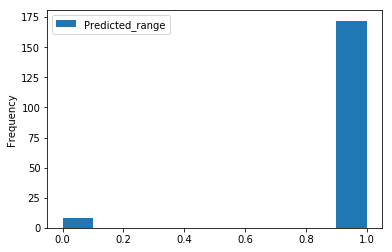

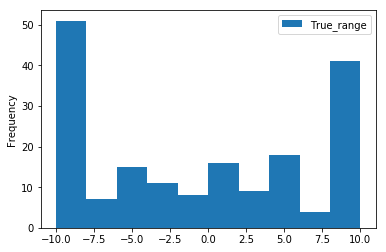

In [5]:
#compile together
#XRP
name=['classification_ merge_EOS-USD.csv','classification_ merge_ZEC-USD.csv','classification_ merge_ETH-USD.csv','classification_ merge_XRP-USD.csv','classification_ merge_LTC-USD.csv']

X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,split_line= load_data(name[3], 30,0.8773)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

model = initialize_model(0.2)
print (model.summary())

model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

successful_rate=find_the_successful_rate(predictions)
successful_rate


(1739, 30, 108)
(1739, 21)
(180, 30, 108)
(180, 21)
30
(180, 21)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 32)            18048     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 21)                693       
Total params: 28,117
Trainable params: 28,117
Non-trainable params: 0
_______

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1565 samples, validate on 174 samples
Epoch 1/100
1565/1565 [==============================] - 6s 4ms/step - loss: 2.6855 - acc: 0.2262 - val_loss: 2.4610 - val_acc: 0.2184
Epoch 2/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.5319 - acc: 0.2537 - val_loss: 2.4386 - val_acc: 0.3103
Epoch 3/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.4921 - acc: 0.2275 - val_loss: 2.4613 - val_acc: 0.3103
Epoch 4/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.4555 - acc: 0.2422 - val_loss: 2.5067 - val_acc: 0.3103
Epoch 5/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.4430 - acc: 0.2364 - val_loss: 2.5220 - val_acc: 0.2184
Epoch 6/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.4469 - acc: 0.2460 - val_loss: 2.4862 - val_acc: 0.3103
Epoch 7/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.4375 - acc: 0.2396 - val_loss: 2.5097 - val_acc: 0.2184
Epoch 8/

Epoch 61/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.1922 - acc: 0.2946 - val_loss: 2.5266 - val_acc: 0.2471
Epoch 62/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.2125 - acc: 0.2978 - val_loss: 2.5436 - val_acc: 0.2184
Epoch 63/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.2306 - acc: 0.2875 - val_loss: 2.5207 - val_acc: 0.2414
Epoch 64/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.1902 - acc: 0.3054 - val_loss: 2.5371 - val_acc: 0.2241
Epoch 65/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.1856 - acc: 0.3073 - val_loss: 2.5224 - val_acc: 0.2471
Epoch 66/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.1832 - acc: 0.3112 - val_loss: 2.6033 - val_acc: 0.2759
Epoch 67/100
1565/1565 [==============================] - 2s 1ms/step - loss: 2.1646 - acc: 0.3086 - val_loss: 2.5383 - val_acc: 0.2356
Epoch 68/100
1565/1565 [========================

0.0278

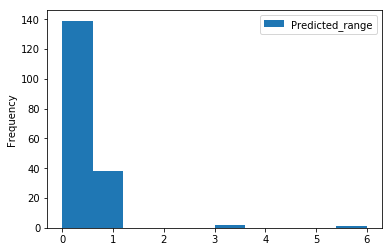

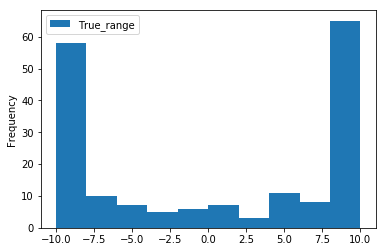

In [6]:
#compile together
#LTC
name=['classification_ merge_EOS-USD.csv','classification_ merge_ZEC-USD.csv','classification_ merge_ETH-USD.csv','classification_ merge_XRP-USD.csv','classification_ merge_LTC-USD.csv']

X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,split_line= load_data(name[4], 30,0.9063)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

model = initialize_model(0.2)
print (model.summary())

model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

successful_rate=find_the_successful_rate(predictions)
successful_rate


(1087, 30, 110)
(1087, 21)
(180, 30, 110)
(180, 21)
30
(180, 21)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 32)            18304     
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 21)                693       
Total params: 28,373
Trainable params: 28,373
Non-trainable params: 0
_______

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 978 samples, validate on 109 samples
Epoch 1/100
978/978 [==============================] - 7s 7ms/step - loss: 2.5253 - acc: 0.3006 - val_loss: 2.5524 - val_acc: 0.2018
Epoch 2/100
978/978 [==============================] - 1s 1ms/step - loss: 2.2721 - acc: 0.3047 - val_loss: 2.5005 - val_acc: 0.2202
Epoch 3/100
978/978 [==============================] - 1s 1ms/step - loss: 2.2558 - acc: 0.3016 - val_loss: 2.4966 - val_acc: 0.2018
Epoch 4/100
978/978 [==============================] - 1s 1ms/step - loss: 2.2488 - acc: 0.3252 - val_loss: 2.4889 - val_acc: 0.2018
Epoch 5/100
978/978 [==============================] - 1s 1ms/step - loss: 2.2439 - acc: 0.3190 - val_loss: 2.4997 - val_acc: 0.2018
Epoch 6/100
978/978 [==============================] - 1s 1ms/step - loss: 2.2369 - acc: 0.3149 - val_loss: 2.4840 - val_acc: 0.2018
Epoch 7/100
978/978 [==============================] - 1s 1ms/step - loss: 2.2273 - acc: 0.3067 - val_loss: 2.4967 - val_acc: 0.2018
Epoch 8/100
978/978 [==

978/978 [==============================] - 1s 700us/step - loss: 2.0499 - acc: 0.3691 - val_loss: 2.5829 - val_acc: 0.2661
Epoch 62/100
978/978 [==============================] - 1s 691us/step - loss: 2.0240 - acc: 0.3814 - val_loss: 2.5853 - val_acc: 0.2569
Epoch 63/100
978/978 [==============================] - 1s 876us/step - loss: 2.0156 - acc: 0.3875 - val_loss: 2.5810 - val_acc: 0.2661
Epoch 64/100
978/978 [==============================] - 1s 762us/step - loss: 2.0145 - acc: 0.3804 - val_loss: 2.5942 - val_acc: 0.2752
Epoch 65/100
978/978 [==============================] - 1s 693us/step - loss: 2.0448 - acc: 0.3793 - val_loss: 2.6301 - val_acc: 0.2202
Epoch 66/100
978/978 [==============================] - 1s 648us/step - loss: 2.0160 - acc: 0.3681 - val_loss: 2.6320 - val_acc: 0.2385
Epoch 67/100
978/978 [==============================] - 1s 625us/step - loss: 2.0081 - acc: 0.3691 - val_loss: 2.6872 - val_acc: 0.2294
Epoch 68/100
978/978 [==============================] - 1s 65

0.0778

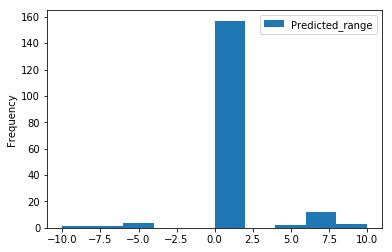

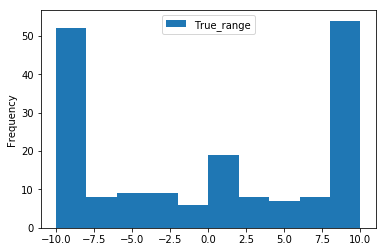

In [7]:
#compile together
#ETH
name=['classification_ merge_EOS-USD.csv','classification_ merge_ZEC-USD.csv','classification_ merge_ETH-USD.csv','classification_ merge_XRP-USD.csv','classification_ merge_LTC-USD.csv']

X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,split_line= load_data(name[2], 30,0.8582)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

model = initialize_model(0.2)
print (model.summary())

model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

successful_rate=find_the_successful_rate(predictions)
successful_rate


(2934, 30, 106)
(2934, 21)
(180, 30, 106)
(180, 21)
30
(180, 21)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 30, 32)            17792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 21)                693       
Total params: 27,861
Trainable params: 27,861
Non-trainable params: 0
_______

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2640 samples, validate on 294 samples
Epoch 1/100
2640/2640 [==============================] - 4s 2ms/step - loss: 2.6401 - acc: 0.2485 - val_loss: 2.6756 - val_acc: 0.1939
Epoch 2/100
2640/2640 [==============================] - 2s 628us/step - loss: 2.5421 - acc: 0.2629 - val_loss: 2.7065 - val_acc: 0.1939
Epoch 3/100
2640/2640 [==============================] - 2s 637us/step - loss: 2.5179 - acc: 0.2595 - val_loss: 2.7688 - val_acc: 0.1939
Epoch 4/100
2640/2640 [==============================] - 2s 614us/step - loss: 2.4863 - acc: 0.2617 - val_loss: 2.8636 - val_acc: 0.2109
Epoch 5/100
2640/2640 [==============================] - 2s 582us/step - loss: 2.4881 - acc: 0.2727 - val_loss: 2.8605 - val_acc: 0.1939
Epoch 6/100
2640/2640 [==============================] - 2s 606us/step - loss: 2.4770 - acc: 0.2580 - val_loss: 2.8871 - val_acc: 0.1939
Epoch 7/100
2640/2640 [==============================] - 2s 623us/step - loss: 2.4666 - acc: 0.2689 - val_loss: 2.8793 - val_acc: 0.2

2640/2640 [==============================] - 2s 627us/step - loss: 2.2308 - acc: 0.3110 - val_loss: 2.8508 - val_acc: 0.1973
Epoch 61/100
2640/2640 [==============================] - 2s 621us/step - loss: 2.2153 - acc: 0.3284 - val_loss: 2.8055 - val_acc: 0.2041
Epoch 62/100
2640/2640 [==============================] - 2s 600us/step - loss: 2.2174 - acc: 0.3216 - val_loss: 2.9108 - val_acc: 0.1939
Epoch 63/100
2640/2640 [==============================] - 2s 601us/step - loss: 2.2218 - acc: 0.3269 - val_loss: 2.8451 - val_acc: 0.2007
Epoch 64/100
2640/2640 [==============================] - 2s 600us/step - loss: 2.2038 - acc: 0.3288 - val_loss: 2.9148 - val_acc: 0.1939
Epoch 65/100
2640/2640 [==============================] - 2s 606us/step - loss: 2.2008 - acc: 0.3288 - val_loss: 2.9315 - val_acc: 0.1939
Epoch 66/100
2640/2640 [==============================] - ETA: 0s - loss: 2.2040 - acc: 0.324 - 2s 600us/step - loss: 2.2002 - acc: 0.3261 - val_loss: 2.8790 - val_acc: 0.1939
Epoch 67/

0.0778

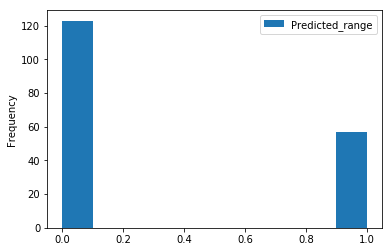

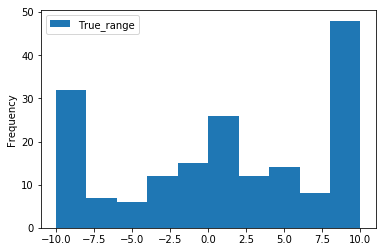

In [8]:

X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,split_line= load_data("Classification_bitcoin.csv", 30,0.9422)

print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

model = initialize_model(0.2)
print (model.summary())

model,history = fit_model(model, X_train, Y_train, 32, 100, .1)

predictions=model_predictions(model, X_test, Y_test)
predictions.head(5)

successful_rate=find_the_successful_rate(predictions)
successful_rate
